In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
IMAGES_DIR = "dichen_output_otsu"
CSV_FILE = "val_annotations.csv"

BASELINE_CKPT = "final_model.pth"
FINETUNED_CKPT = "finetuned_model.pth"

NUM_CLASSES = 2
BATCH_SIZE = 1
NUM_WORKERS = 0
SCORE_THRESH = 0.5
IOU_THRESH = 0.5

print("device:", device)
print("images dir:", IMAGES_DIR)
print("csv file:", CSV_FILE)
print("baseline ckpt:", BASELINE_CKPT)
print("finetuned ckpt:", FINETUNED_CKPT)

device: cuda
images dir: dichen_output_otsu
csv file: val_annotations.csv
baseline ckpt: final_model.pth
finetuned ckpt: finetuned_model.pth


In [3]:
class NumberPlateDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform

        if "filename" not in self.data_frame.columns:
            raise ValueError("CSV must contain a 'filename' column.")

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_path = os.path.join(self.images_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")

        xmin = float(row["xmin"])
        ymin = float(row["ymin"])
        xmax = float(row["xmax"])
        ymax = float(row["ymax"])

        boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform is not None:
            image = self.transform(image)

        return image, target


def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)


eval_transform = T.Compose([T.ToTensor()])

eval_dataset = NumberPlateDataset(CSV_FILE, IMAGES_DIR, transform=eval_transform)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == "cuda" else False,
)

len(eval_dataset)

19

In [4]:
def build_model(num_classes, ckpt_path):
    model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if ckpt_path is not None and os.path.exists(ckpt_path):
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()
    return model


baseline_model = build_model(NUM_CLASSES, BASELINE_CKPT)
finetuned_model = build_model(NUM_CLASSES, FINETUNED_CKPT)

baseline_model.eval()
finetuned_model.eval()

"models_ready"

'models_ready'

In [5]:
def box_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h

    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    union = area_a + area_b - inter

    if union <= 0:
        return 0.0

    return inter / union


@torch.no_grad()
def evaluate_metrics(model, data_loader, device, score_thresh=0.5, iou_thresh=0.5):
    model.eval()
    ious = []
    detected = 0
    total = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            total += 1

            gt_boxes = tgt["boxes"].cpu().numpy()
            pred_boxes = out["boxes"].detach().cpu().numpy()
            scores = out["scores"].detach().cpu().numpy()

            if len(pred_boxes) == 0:
                continue

            idx = int(np.argmax(scores))
            if scores[idx] < score_thresh:
                continue

            pred = pred_boxes[idx]
            gt = gt_boxes[0]

            iou = box_iou(pred, gt)

            if iou >= iou_thresh:
                detected += 1

            ious.append(iou)

    avg_iou = float(np.mean(ious)) if len(ious) > 0 else 0.0
    det_rate = detected / max(1, total)
    return avg_iou, det_rate

In [6]:
baseline_iou, baseline_det = evaluate_metrics(
    baseline_model,
    eval_loader,
    device,
    score_thresh=SCORE_THRESH,
    iou_thresh=IOU_THRESH,
)

finetuned_iou, finetuned_det = evaluate_metrics(
    finetuned_model,
    eval_loader,
    device,
    score_thresh=SCORE_THRESH,
    iou_thresh=IOU_THRESH,
)

print("dataset size:", len(eval_dataset))
print("Baseline  avg IoU:", baseline_iou)
print("Baseline  det rate:", baseline_det)
print("Finetuned avg IoU:", finetuned_iou)
print("Finetuned det rate:", finetuned_det)

dataset size: 19
Baseline  avg IoU: 0.296835290061103
Baseline  det rate: 0.15789473684210525
Finetuned avg IoU: 0.5737715271803049
Finetuned det rate: 0.5263157894736842


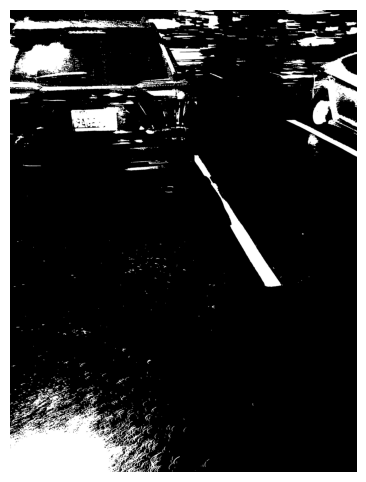

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

@torch.no_grad()
def visualize_prediction_on_path(model, img_path, transform=None, score_thresh=0.5):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    if transform is not None:
        image = transform(img)
    else:
        image = T.ToTensor()(img)
    model_input = [image.to(device)]
    outputs = model(model_input)
    output = outputs[0]
    img_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img_np)
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    for (xmin, ymin, xmax, ymax), s in zip(boxes, scores):
        if s < score_thresh:
            continue
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f"{s:.2f}", color="r", fontsize=8)
    plt.axis("off")
    plt.show()

transform = T.Compose([T.ToTensor()])
# test_image_path = "./images/IMG_1882.jpg"
test_image_path = "./dichen_output_otsu/IMG_1896.jpg"
visualize_prediction_on_path(baseline_model, test_image_path, transform=transform, score_thresh=0.5)
